# IE0005 Group Project (EL02)
### Group Members: 
##### Beh Hoa Wing (U2220707K)
##### Carissa Metta Fernandez (U2222329F)
##### Leong See Neng Shannon (U2222007D)
##### Joey Low Jia Xin (U2222739C)
### Topic: Cardivascular Diseases

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, classification_report, roc_curve,precision_recall_curve, auc,confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


import random
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 15)]

# EDA

In [2]:
cardioData = pd.read_csv('cardio_train2.csv')
cardioData.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
cardioData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Numeric Vars: age, height, weight, ap_hi, ap_lo
Categorical Vars: 
    norminal: gender
    Ordinal: Cholesterol, gluc, smoke, alco, active

Based on kaggle

In [4]:
cardioData.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

No missing values

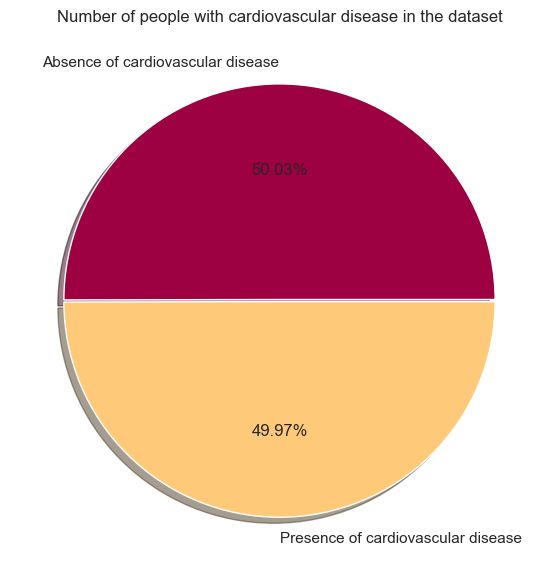

In [5]:
sb.set(style="whitegrid")
random.shuffle(colors)
labels = ["Absence of cardiovascular disease", "Presence of cardiovascular disease"]
values = cardioData['cardio'].value_counts().tolist()

plt.figure(figsize=(7,7))
plt.pie(x=values, labels=labels, autopct="%1.2f%%", colors=colors, shadow=True, explode=[0,0.01])
plt.title("Number of people with cardiovascular disease in the dataset", fontdict={'fontsize': 12})
plt.show()

In [6]:
cardioNumerical = cardioData[['age','height','weight','ap_hi','ap_lo','cardio']]

cardioNumerical.describe()

,age,height,weight,ap_hi,ap_lo,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,164.359229,74.205690,128.817286,96.630414,0.499700
std,2467.251667,8.210126,14.395757,154.011419,188.472530,0.500003
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000,0.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000,0.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000,0.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000,1.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000,1.000000


# Removing Noise 

Problem 1: Min weight = 10kg and min height = 55cm

Problem 2: The max and min of blood pressure is off. Highest recorded human blood pressure was 370/360 mmhg and BP lower than 90/60mmhg are considered hypotension.

Problem 3: Daistolic pressure cannot be hgiher than systolic pressure.

In [7]:
print("Daistolic pressure is higher than systolic in {0} cases".format(cardioData[cardioData['ap_lo']> cardioData['ap_hi']].shape[0]))


Daistolic pressure is higher than systolic in 1234 cases


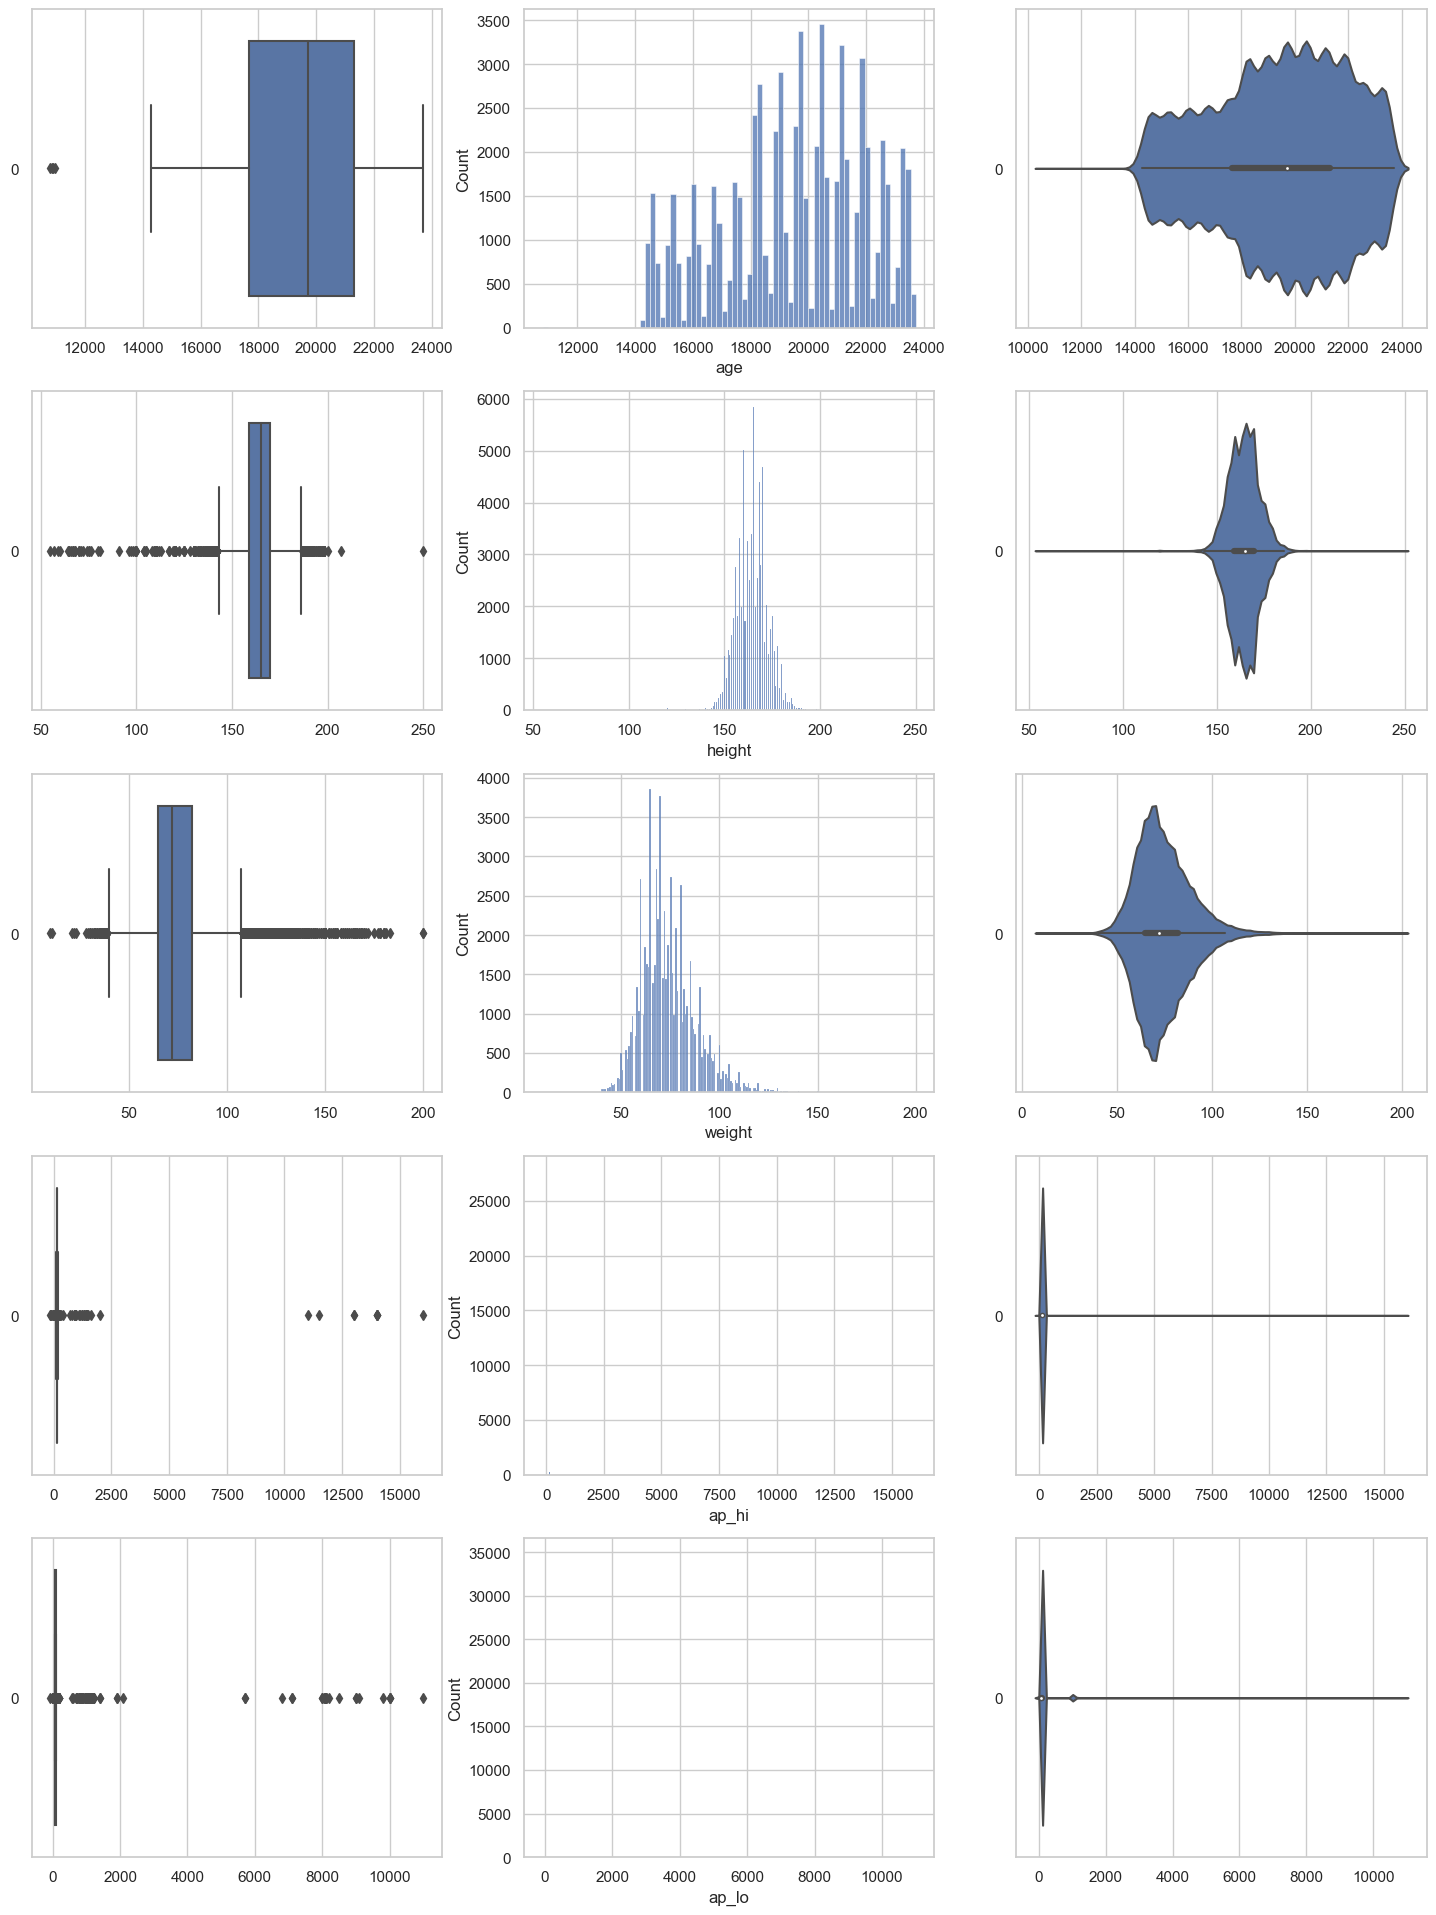

In [8]:
f, axes = plt.subplots(5, 3, figsize=(18, 24))
count = 0
for var in cardioNumerical:
    if (var!='cardio'):
        sb.boxplot(data = cardioNumerical[var], orient = "h", ax = axes[count,0])
        sb.histplot(data = cardioNumerical[var], ax = axes[count,1])
        sb.violinplot(data = cardioNumerical[var], orient = "h", ax = axes[count,2])
        count += 1

## Numberical Data Cleaning
    
Based on the problems we identited as impossible.

In [9]:
abnormalbp = cardioData['ap_hi']<cardioData['ap_lo']
cardioData.drop(cardioData[abnormalbp].index, inplace=True)
print("Number of case where Daistolic pressure is higher than Systolic pressure : {0}.".format(cardioData[cardioData['ap_lo']> cardioData['ap_hi']].shape[0]))


Number of case where Daistolic pressure is higher than Systolic pressure : 0.


In [10]:
print("Data Dims : ",cardioData.shape)

Data Dims :  (68766, 13)


### Removing Outliers (by using turkey fence method)

Outliers can be defined as value that lies 3.0 IQR beyond the 1st and 3rd quartiles.

In [11]:
#Making a function to remove outliers
def flag_outliers(df, var, degree):
    #Getting the interquartile range
    lq = df[var].quantile(0.25)
    uq = df[var].quantile(0.75)
    iqr = uq - lq
    #Generating Upper/Lower Bounds
    lowerbound = lq - degree*iqr
    upperbound = uq + degree*iqr
    #Adding a column with a boolean flag to flag out anomalies
    df['flag'] = 0
    df.loc[(df[var] <= lowerbound) | (df[var] >= upperbound), 'flag'] = 1
    #Show a scatterplot of the values to be dropped
    f, axes = plt.subplots(1, 1, figsize=(16,8))
    plt.scatter(x = var, y = "id", c = "flag", cmap = 'viridis', data = df)
    total=df['flag'].sum()
    print('Total no. of values to be dropped:',total)
    del df['flag']
    return lowerbound, upperbound

In [12]:
def drop_outliers(df, var, lowerbound, upperbound):
    df.drop(df[(df[var] <= lowerbound) | (df[var] >= upperbound)].index,inplace=True)
    
    #Plot boxplot of variable after dropping
    sb.boxplot(data = df[var], orient = "h")

Total no. of values to be dropped: 195


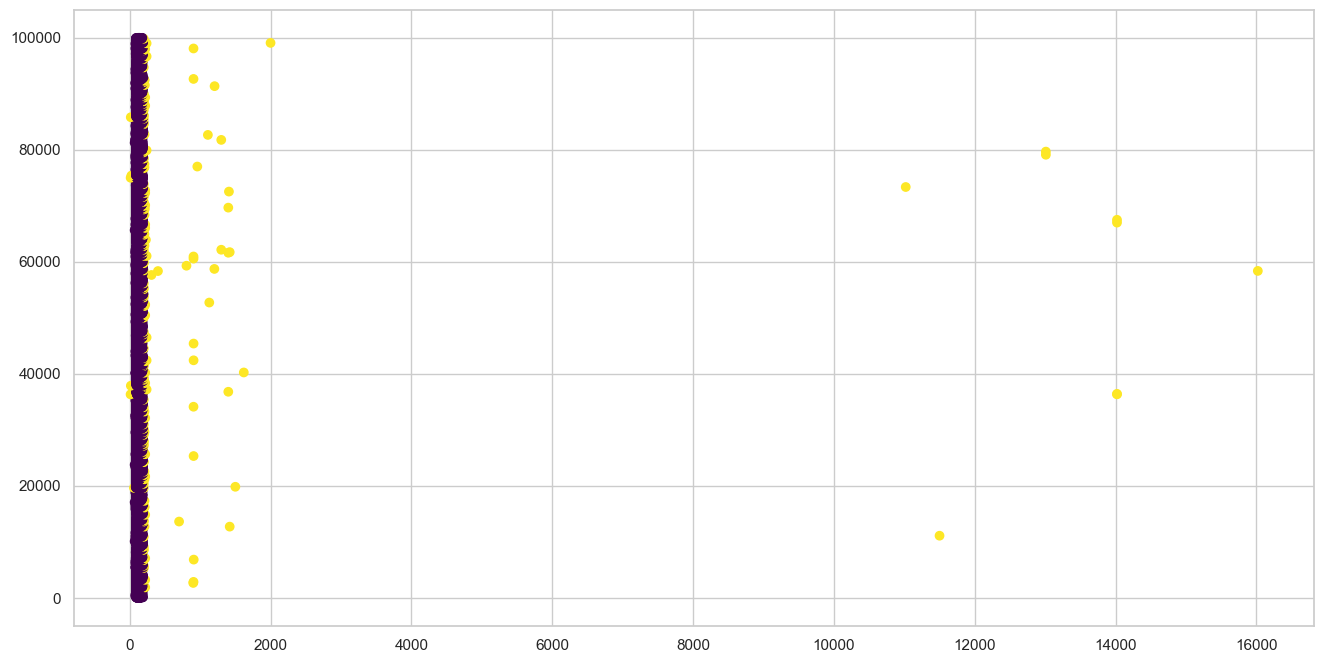

In [13]:
lowerbound, upperbound = flag_outliers(cardioData, 'ap_hi', 3)

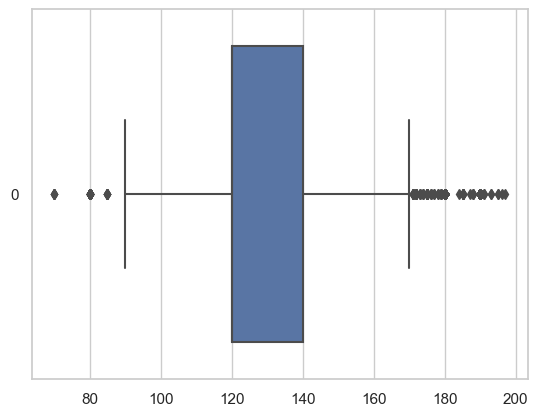

In [14]:
drop_outliers(cardioData, 'ap_hi', lowerbound, upperbound)

ap_hi data is now normal distribution

In [15]:
cardioData.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68571.000000,68571.00000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000,68571.000000
mean,49969.259060,19462.82933,1.348354,164.360371,74.091861,126.500868,81.192210,1.363871,1.225095,0.087763,0.053200,0.803445,0.493926
std,28846.774087,2468.79351,0.476452,8.186520,14.307359,16.287805,9.487811,0.678382,0.571000,0.282952,0.224434,0.397396,0.499967
min,0.000000,10798.00000,1.000000,55.000000,11.000000,70.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24994.500000,17656.00000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50005.000000,19700.00000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74864.500000,21323.00000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.00000,2.000000,250.000000,200.000000,197.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


ap_hi and ap_low are now cleaned. Now we need to clean height and weight

### Removing height outliers

Total no. of values to be dropped: 89


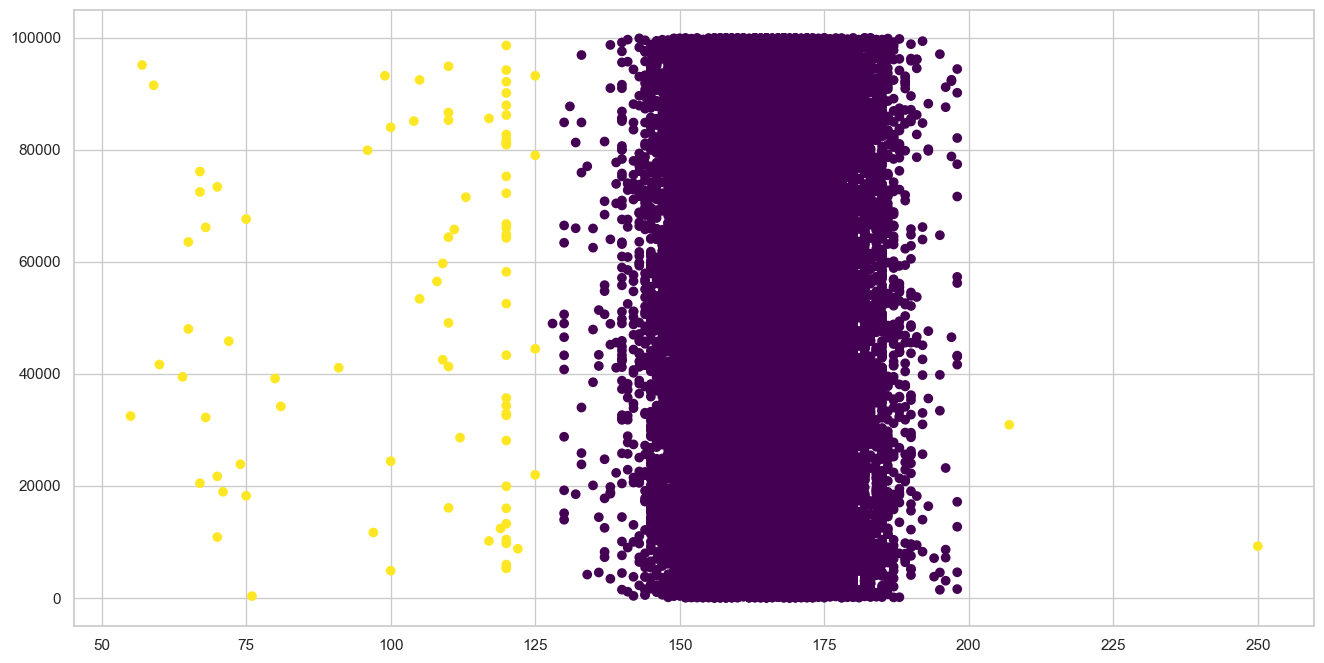

In [16]:
lowerbound, upperbound = flag_outliers(cardioData, 'height', 3)

data dropped 89/68766 = 0.12%

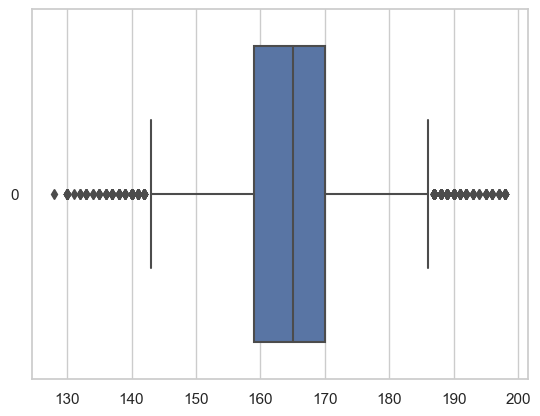

In [17]:
drop_outliers(cardioData, 'height', lowerbound, upperbound)

### Removing outliers based on Weight 

Total no. of values to be dropped: 160


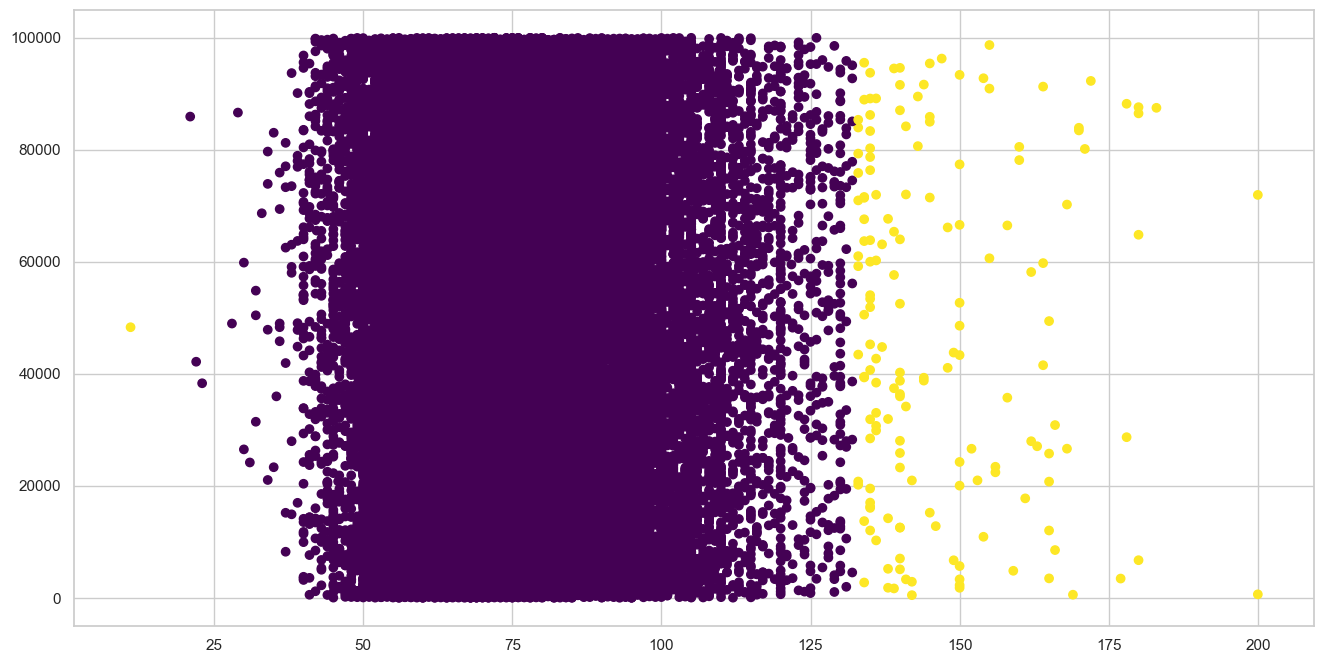

In [18]:
lowerbound, upperbound = flag_outliers(cardioData, 'weight', 3)

160/68766= 0.23% to be droppped

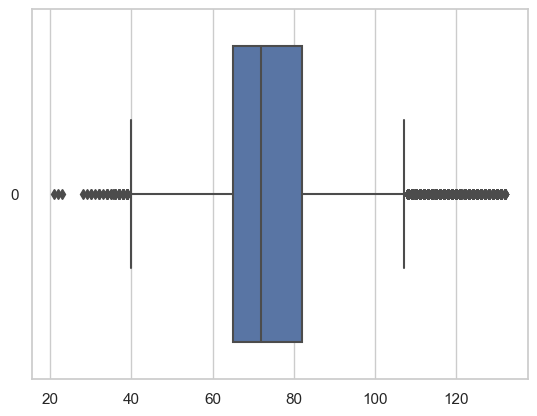

In [19]:
drop_outliers(cardioData, 'weight', lowerbound, upperbound)

In [20]:
cardioData.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68322.000000,68322.00000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000,68322.000000
mean,49972.840783,19464.38440,1.348116,164.423861,73.912684,126.474401,81.178493,1.363558,1.224569,0.087644,0.053072,0.803519,0.493384
std,28842.164472,2468.54202,0.476377,7.836948,13.831609,16.270779,9.474229,0.678157,0.570487,0.282778,0.224179,0.397340,0.499960
min,0.000000,10798.00000,1.000000,128.000000,21.000000,70.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.250000,17657.00000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50011.000000,19701.00000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74856.750000,21325.00000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.00000,2.000000,198.000000,132.000000,197.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


### Removing Outlier on ap_lo

Total no. of values to be dropped: 277


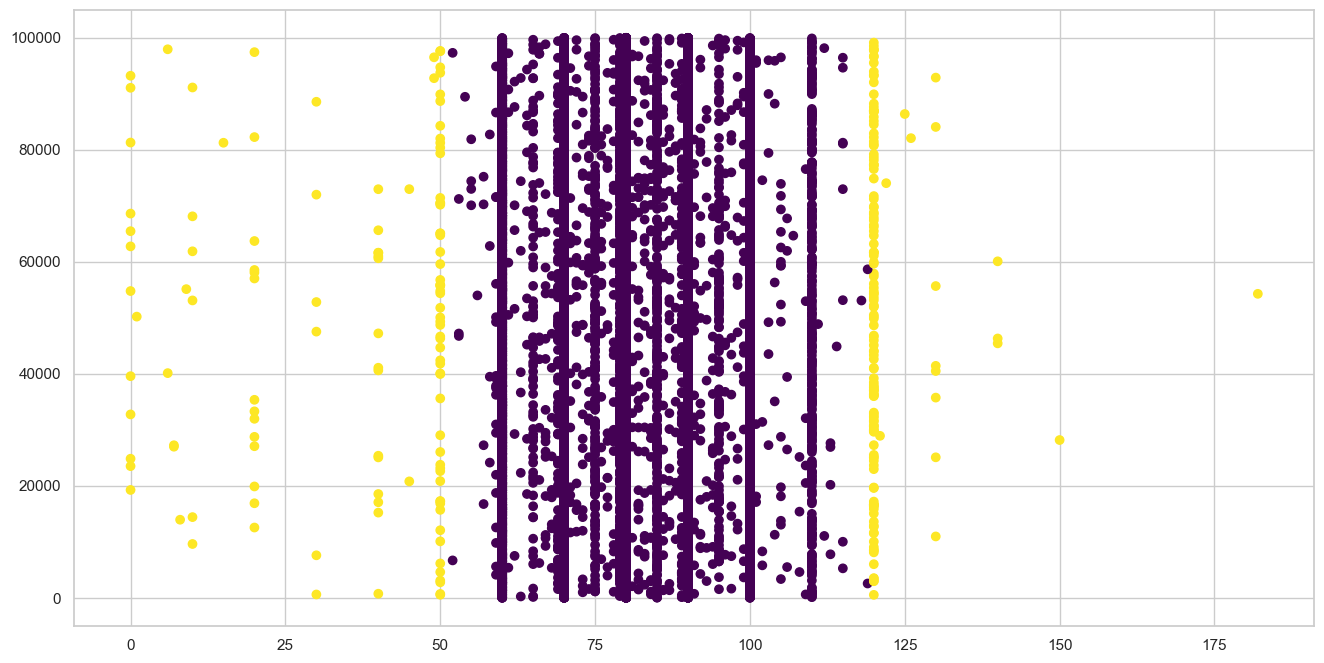

In [21]:
lowerbound, upperbound = flag_outliers(cardioData, 'ap_lo', 3)

3 degree is to close to the normal distribution.

Total no. of values to be dropped: 51


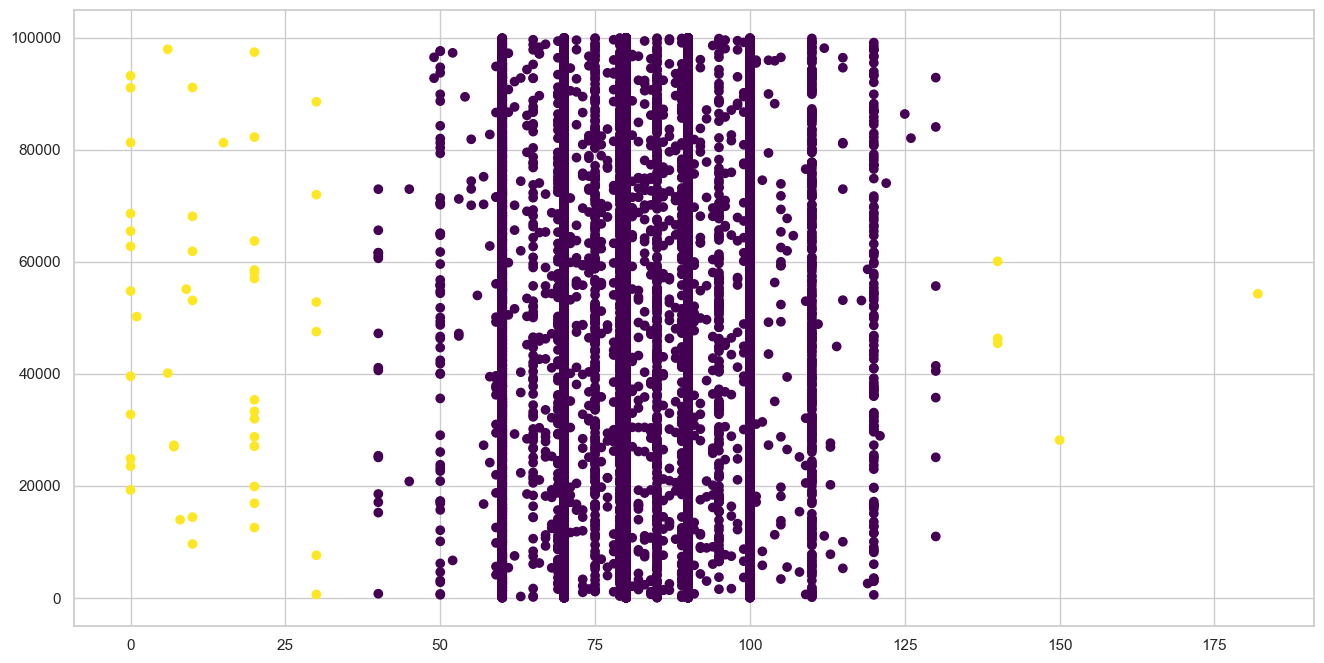

In [22]:
lowerbound, upperbound = flag_outliers(cardioData, 'ap_lo', 5)

61/68766 = 0.07% dropped

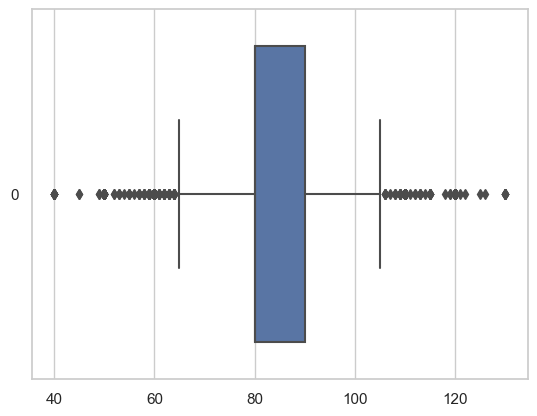

In [23]:
drop_outliers(cardioData, 'ap_lo', lowerbound, upperbound)

### Overall shape of Cleaned Data

In [24]:
cardioData.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000
mean,49973.927612,19464.580613,1.348113,164.423708,73.913249,126.470844,81.219639,1.363536,1.224663,0.087651,0.053083,0.803474,0.493372
std,28844.168991,2468.523183,0.476375,7.837376,13.831120,16.262321,9.285198,0.678127,0.570606,0.282788,0.224200,0.397373,0.499960
min,0.000000,10798.000000,1.000000,128.000000,21.000000,70.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25002.500000,17657.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50010.000000,19701.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74860.500000,21325.500000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,198.000000,132.000000,197.000000,130.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
print(cardioData.shape)

(68271, 13)


We have removed 2.47% of the original data as outliers

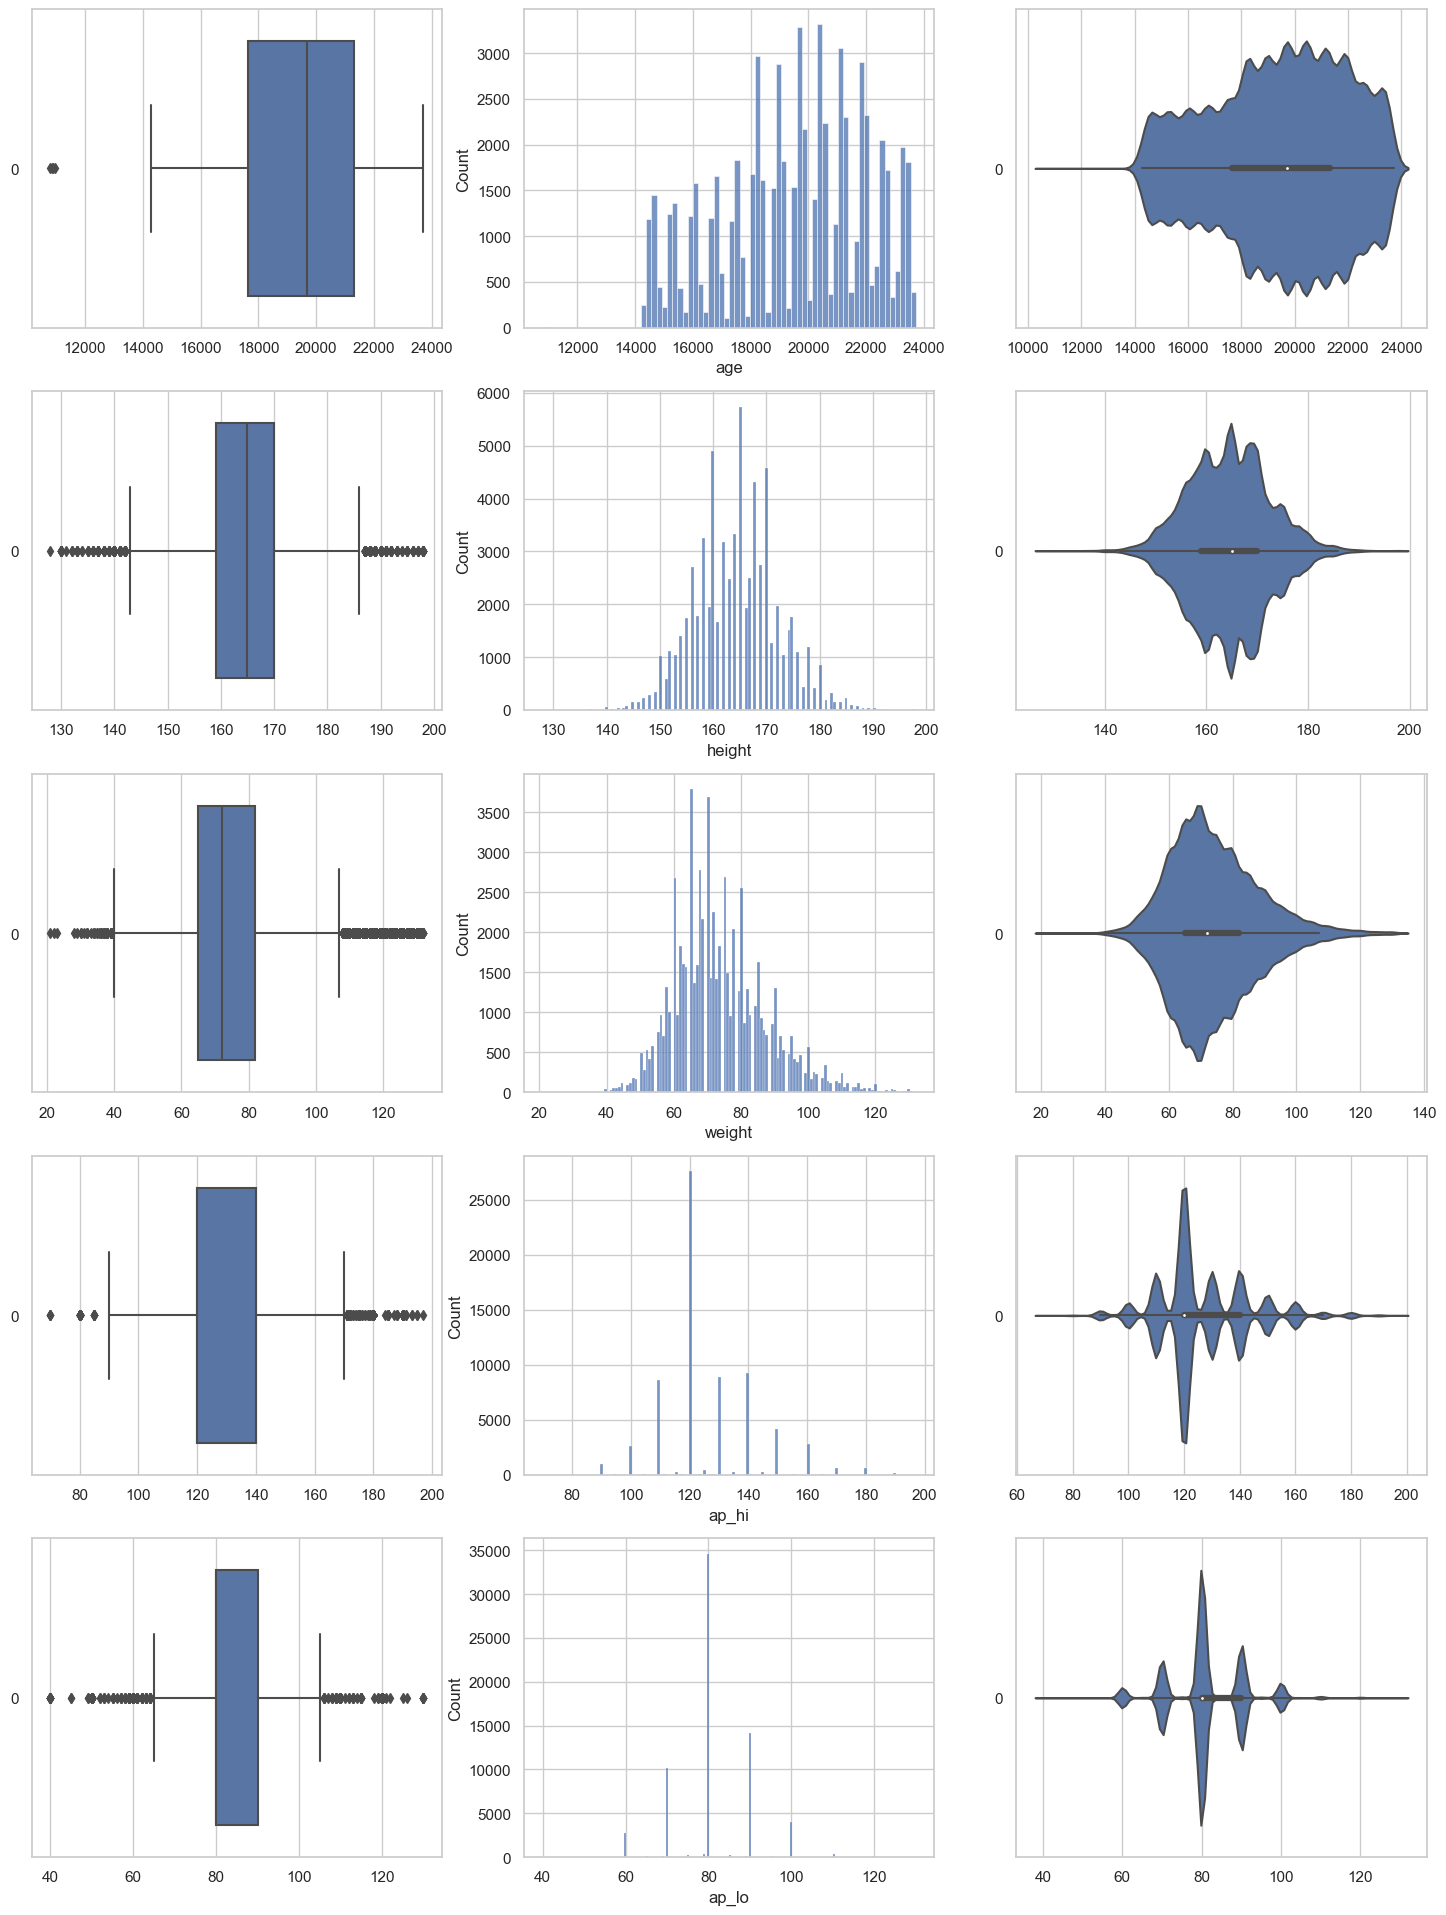

In [26]:
dfNumerical=cardioData[['age', 'height', 'weight', 'ap_hi', 'ap_lo','cardio']]
f, axes = plt.subplots(5, 3, figsize=(18, 24))
count = 0
for var in dfNumerical:
    if (var!='cardio'):
        sb.boxplot(data = dfNumerical[var], orient = "h", ax = axes[count,0])
        sb.histplot(data = dfNumerical[var], ax = axes[count,1])
        sb.violinplot(data = dfNumerical[var], orient = "h", ax = axes[count,2])
        count += 1

Now age, height, weight, ap_hi and ap_low followed a normal distribution.

<AxesSubplot:>

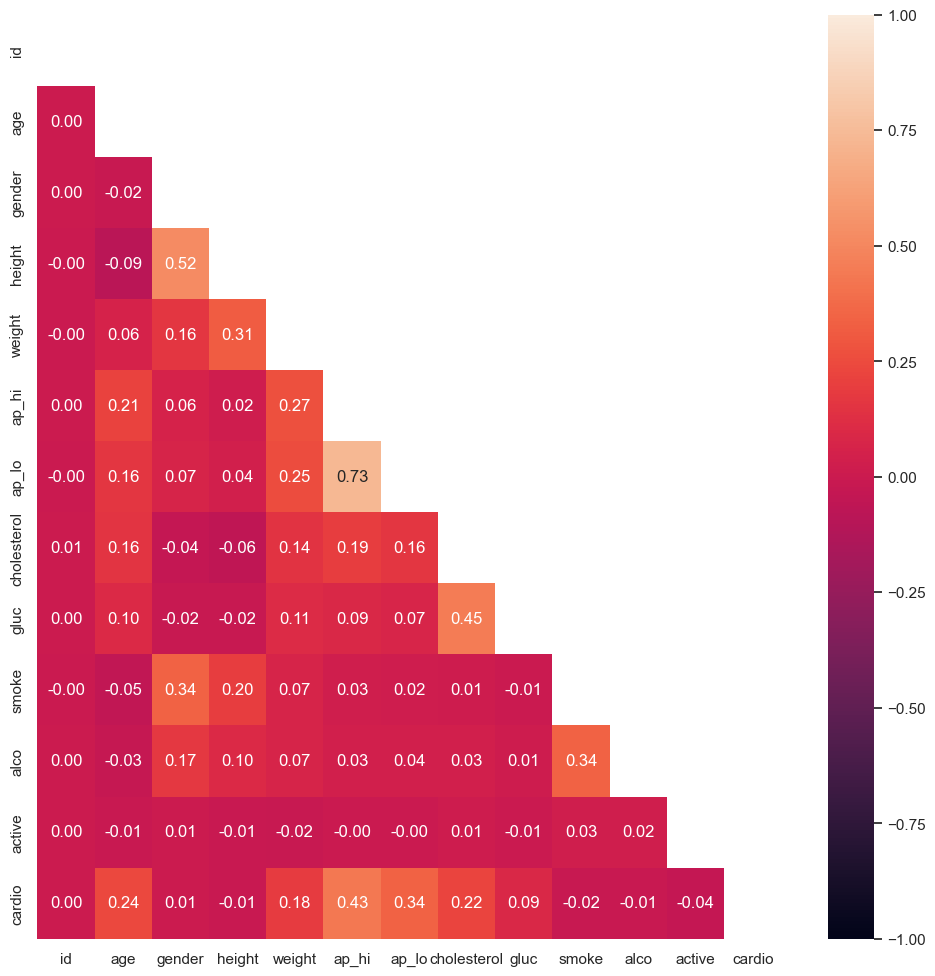

In [27]:
#Plotting a correlation matrix between the variables
f = plt.figure(figsize=(12, 12))
mask = np.triu(np.ones_like(cardioData.corr(), dtype=bool))
sb.heatmap(cardioData.corr(), mask=mask, vmin = -1, vmax = 1, annot = True, fmt = ".2f")

ap_hi and ap_low seems to be a main factor of CDV, followed by cholesterol 

### Mean Blood Pressure (MBP) = diastolic blood pressure + 1/3(systolic blood pressure - dbp)

In [28]:
age = pd.DataFrame(cardioData['age'])
height = pd.DataFrame(cardioData['height'])
weight = pd.DataFrame(cardioData['weight'])
gender = pd.DataFrame(cardioData['gender'])
cholesterol = pd.DataFrame(cardioData['cholesterol'])
glucose = pd.DataFrame(cardioData['gluc'])
smoke = pd.DataFrame(cardioData['smoke'])
alcohol = pd.DataFrame(cardioData['alco'])
active = pd.DataFrame(cardioData['active'])

In [29]:
ap_hi = pd.DataFrame(cardioData['ap_hi'])
ap_low = pd.DataFrame(cardioData['ap_lo'])

def mean_blood_pressure(ap_hi, ap_lo):
        mbp = (ap_hi + 2 * ap_lo) / 3
        return mbp

cardioData['Mean_Blood_Pressure'] = mean_blood_pressure(cardioData['ap_hi'], cardioData['ap_lo'])

cardioData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68271 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   68271 non-null  int64  
 1   age                  68271 non-null  int64  
 2   gender               68271 non-null  int64  
 3   height               68271 non-null  int64  
 4   weight               68271 non-null  float64
 5   ap_hi                68271 non-null  int64  
 6   ap_lo                68271 non-null  int64  
 7   cholesterol          68271 non-null  int64  
 8   gluc                 68271 non-null  int64  
 9   smoke                68271 non-null  int64  
 10  alco                 68271 non-null  int64  
 11  active               68271 non-null  int64  
 12  cardio               68271 non-null  int64  
 13  Mean_Blood_Pressure  68271 non-null  float64
dtypes: float64(2), int64(12)
memory usage: 9.8 MB


# Modelling of Data



In [30]:
del cardioData['id']
cardioData.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Mean_Blood_Pressure
count,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000,68271.000000
mean,19464.580613,1.348113,164.423708,73.913249,126.470844,81.219639,1.363536,1.224663,0.087651,0.053083,0.803474,0.493372,96.303374
std,2468.523183,0.476375,7.837376,13.831120,16.262321,9.285198,0.678127,0.570606,0.282788,0.224200,0.397373,0.499960,10.799400
min,10798.000000,1.000000,128.000000,21.000000,70.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,50.000000
25%,17657.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,93.333333
50%,19701.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,93.333333
75%,21325.500000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,103.333333
max,23713.000000,2.000000,198.000000,132.000000,197.000000,130.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,151.666667


## Train and Test data (mbp vs cdv)

### Test (75%) Train (25%)

In [31]:
# Split the Legendary-Total Dataset into Train and Test
y = pd.DataFrame(cardioData["cardio"])                          # response
X = pd.DataFrame(cardioData[["ap_hi", "ap_lo", "cholesterol"]]) # predictors

# Split the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Linear Regression
Since the predictor variable is a boolean data which only takes in 2 values, using a linear regression model will not help us achieve the results we want as the relationship between the predictor and the response variable is non-linear.

###       1. Decision tree classification
Decision tree classification is a popular machine learning algorithm because it is simple to understand and interpret, and can handle both categorical and numerical data. Decision trees are used for both classification and regression tasks.

-------------------------------------------
Accuracy of Decision Tree: 72.60370283571595 

-------------------------------------------


NameError: name 'y_train_pred' is not defined

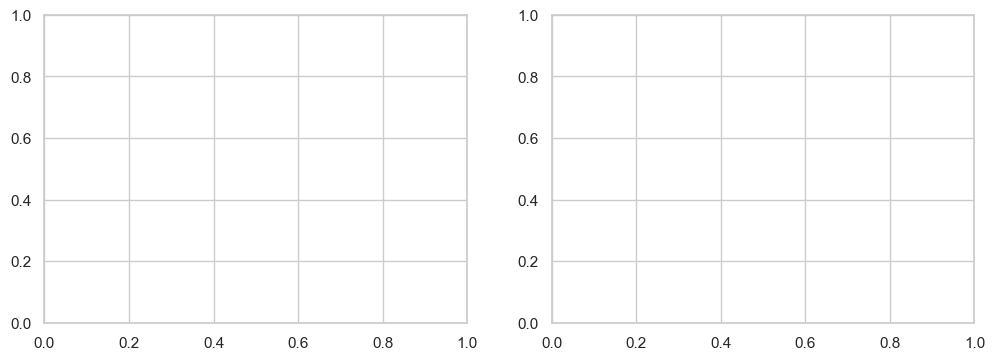

In [32]:
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
dt_train_pred = dectree.predict(X_train)
dt_test_pred = dectree.predict(X_test)

#Accuracy of dt
dt_acc_score = accuracy_score(y_test, dt_test_pred)
print("-------------------------------------------")
print("Accuracy of Decision Tree:",dt_acc_score*100,'\n')
print("-------------------------------------------")

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Plot the Decision Tree
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(48, 6))
out = plot_tree(dectree, 
          feature_names = X_train.columns,
          class_names = [str(x) for x in dectree.classes_],
          filled=True)

for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
        
plt.show()

### 2. Logistic Regression
Logistic regression is a method for binary classification. It models the probability of an event occurring (in this case, having cardiovascular disease) based on the input features (blood pressure and cholesterol levels). Logistic regression can provide interpretable results and is relatively simple to implement.

Logistic regression is used instead of linear regression as linear regression can only be used when the dependent variable is continuous and can take on any value within a range, hence, logistic regression is used instead as the dependent variable is binary (0 or 1).

c:\Users\wingb\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confussion matrix
[[6912 1787]
 [3011 5358]]
-------------------------------------------
Accuracy of Logistic Regression: 71.8889149285212 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      8699
           1       0.75      0.64      0.69      8369

    accuracy                           0.72     17068
   macro avg       0.72      0.72      0.72     17068
weighted avg       0.72      0.72      0.72     17068



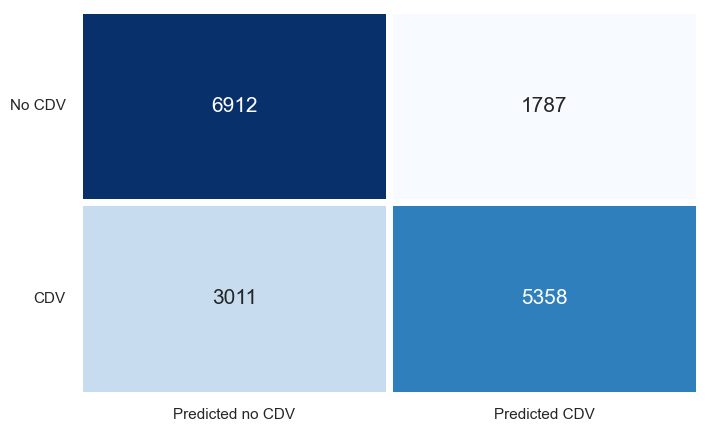

In [ ]:
model_lgr = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,lr_predict))



# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sb.heatmap(lr_conf_matrix, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No CDV', 'CDV'], xticklabels = ['Predicted no CDV', 'Predicted CDV'])
plt.yticks(rotation = 0)
plt.show()

### 3. Gradient Boosting Classifier
Gradient boosting models, such as XGBoost are powerful ensemble methods that can achieve high accuracy in binary classification tasks. They are known for their ability to handle complex interactions between features and handle imbalanced datasets.

confussion matrix
[[7142 1557]
 [3296 5073]]
-------------------------------------------
Accuracy of Extreme Gradient Boost: 71.56667447855637 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.82      0.75      8699
           1       0.77      0.61      0.68      8369

    accuracy                           0.72     17068
   macro avg       0.72      0.71      0.71     17068
weighted avg       0.72      0.72      0.71     17068



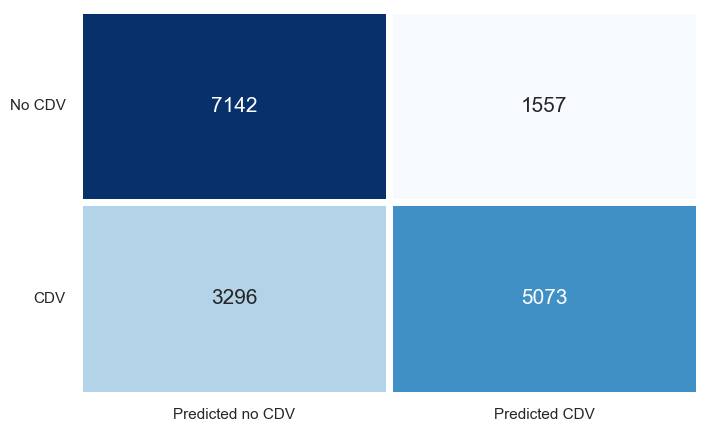

In [ ]:
from xgboost import XGBClassifier
model_egb = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=15, max_depth=10,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("confussion matrix")
print(xgb_conf_matrix)
print("-------------------------------------------")
print("Accuracy of Extreme Gradient Boost:",xgb_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,xgb_predicted))

plt.figure(figsize = (8, 5))
sb.heatmap(xgb_conf_matrix, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No CDV', 'CDV'], xticklabels = ['Predicted no CDV', 'Predicted CDV'])
plt.yticks(rotation = 0)
plt.show()

### 4. Stochastic Gradient Descent
SGD can be used in combination with appropriate models, such as logistic regression or support vector machines, to train a binary classification model that predicts whether a patient has cardiovascular disease based on input features such as blood pressure, cholesterol level, age, etc

c:\Users\wingb\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confussion matrix
[[6963 1736]
 [3321 5048]]
-------------------------------------------
Accuracy of : Stochastic Gradient Descent 70.37145535505039 

-------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.80      0.73      8699
           1       0.74      0.60      0.67      8369

    accuracy                           0.70     17068
   macro avg       0.71      0.70      0.70     17068
weighted avg       0.71      0.70      0.70     17068



(array([0.5, 1.5]), [Text(0, 0.5, 'No CDV'), Text(0, 1.5, 'CDV')])

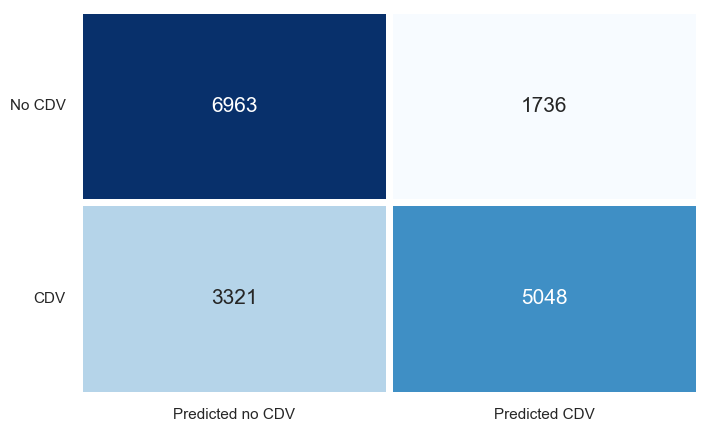

In [ ]:
model_sgd = 'Stochastic Gradient Descent'
sgdc = SGDClassifier(max_iter=5000, random_state=0)
sgdc.fit(X_train, y_train)
sgdc_predicted = sgdc.predict(X_test)
sgdc_conf_matrix = confusion_matrix(y_test, sgdc_predicted)
sgdc_acc_score = accuracy_score(y_test, sgdc_predicted)
print("confussion matrix")
print(sgdc_conf_matrix)
print("-------------------------------------------")
print("Accuracy of : Stochastic Gradient Descent",sgdc_acc_score*100,'\n')
print("-------------------------------------------")
print(classification_report(y_test,sgdc_predicted))

plt.figure(figsize = (8, 5))
sb.heatmap(sgdc_conf_matrix, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No CDV', 'CDV'], xticklabels = ['Predicted no CDV', 'Predicted CDV'])
plt.yticks(rotation = 0)

### Accuracy of different methods

In [ ]:
model_ev = pd.DataFrame({'Model': ['Decision Tree','Logistic Regression',
                    'Extreme Gradient Boost','Stochastic Gradient Descent'], 'Accuracy': [dt_acc_score*100,
                    lr_acc_score*100,xgb_acc_score*100, sgdc_acc_score*100]})
model_ev

,Model,Accuracy
0,Decision Tree,72.035388
1,Logistic Regression,71.888915
2,Extreme Gradient Boost,71.566674
3,Stochastic Gradient Descent,70.371455


# Conclusion
Based on these results, Decision Tree Classification is the most accurate model to use for prediction while SGD is the least accurate. 
Most of the models used have an accuracy of ≥ 70%, which suggests that they are accurate in predicting the presence of CDV based on it inputs variables.
Therefore, we can conclude that Decision Tree Classification yields an accuracy of 72%. This makes it a decent model for predicting what are the leading causes of cardiovascular diseases, in this case, blood pressure and cholesterol, which is the main objective of this project.